# RANSAC

It is well known that least squares parameter estimation is not resistent, i.e. sensitive to outliers. Even one outlier may break least squares estimation, which means a possibly infinitely large parameter bias.

This problem is effectively solved by **RANSAC (RANdom Sample And Consensus)** introduced By Fischler and Bolles in 1981. They solved a problem with a large percent of outliers in the input data. Even 50% of outliers may be tolerated by RANSAC.

Therefore RANSAC is a resistent iterative parameter estimation procedure that uses a subset of data consistent with a model. At each iteration step the procedure works as follows:

1. Select a random minimal sample from data and check conformity
2. Estimate model and check its validity
3. Classify data as conform or outlier based on deviations from the model - data are conform if deviations are below threshold
4. Keep model if the number of conform data is maximum.

Iteration ends upon reaching a specified maximum number or upon a specific criterion. Model parameters are then estimated using the best model.

## RANSAC ellipse fitting

RANSAC is illustrated with a simple problem.

Generate conform data that approximately fit on an ellipse:

In [1]:
import numpy as np
t = np.linspace(0, 2 * np.pi, 50)
a = 10
b = 5
xc = 20
yc = 30
theta = np.pi/6
x = xc + a*np.cos(theta)*np.cos(t) - b*np.sin(theta)*np.sin(t)
y = yc + a*np.sin(theta)*np.cos(t) + b*np.cos(theta)*np.sin(t)
data = np.column_stack([x, y])
# for reproducibility:
np.random.seed(seed=1234)
data += np.random.normal(size=data.shape)

Add some outliers:

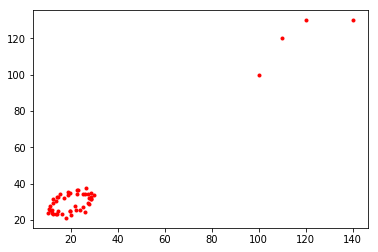

In [2]:
data[0] = (100, 100)
data[1] = (110, 120)
data[2] = (120, 130)
data[3] = (140, 130)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data[:,0],data[:,1],'r.')
plt.show()

### Use total least squares estimation

The image processing library [Scikit-image](http://scikit-image.org) will be used for estimation. It contains implementation of both least squares and RANSAC estimation that can be used for our problem.

In [4]:
import skimage.measure as sm
model = sm.EllipseModel()
model.estimate(data)
# ellipse parameters:
# xc, yc, a, b, theta
np.set_printoptions(suppress=True)
model.params

[73.53514375553581,
 78.26758207007087,
 9.29496368832247,
 80.77273222348025,
 2.303948938231546]

Ezek a paraméterek láthatóan teljesen rosszak. Az eredeti ellipszis fél tengelyhosszai 10 és 5 voltak, a középpont pedig az $O(20,30)$ koordinátájú pont.

### Végezzünk becslést RANSAC eljárással

In [6]:
# at least 5 points are needed for ellipse fitting
n_min = 5
# maximum distance of conform points
t_max = 3.0
ransac_model, inliers = sm.ransac(data, sm.EllipseModel, n_min, t_max, max_trials=50)
print(ransac_model.params)
original_params = np.array([xc,yc,a,b,theta])
print(original_params - ransac_model.params)

[20.056885019810036, 29.543602080886277, 5.453222019610929, 9.289882323249083, 2.0438231698766316]
[-0.05688502  0.45639792  4.54677798 -4.28988232 -1.52022439]


Conform data were found and stored in array 'inliers' as logical 'True' elements:

In [7]:
inliers

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

We see that the first four data are outliers that were added by us.

### Plot best fitting ellipse to conform data

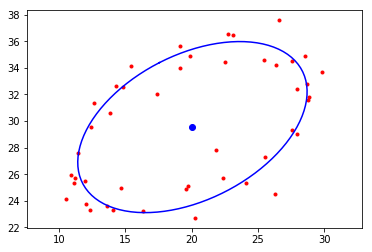

In [9]:
t = np.linspace(0, 2 * np.pi, 100)
p = ransac_model.params
xe = p[0] + p[2]*np.cos(p[4])*np.cos(t) - p[3]*np.sin(p[4])*np.sin(t)
ye = p[1] + p[2]*np.sin(p[4])*np.cos(t) + p[3]*np.cos(p[4])*np.sin(t)
plt.clf()
plt.plot(data[inliers,0],data[inliers,1],'r.')
plt.plot(xe,ye,'b-')
plt.plot(p[0],p[1],'bo')
plt.axis('equal')
plt.show()

Next we first determine position and radius of a reference sphere using laser scanner data.([SphRANSAC](https://nbviewer.jupyter.org/github/gyulat/Korszeru_matek/blob/master/SphRANSAC_en.ipynb)). Then we solve a more complicated geometrical problem: determine parameters of a best fitting right circular cylinder using a point cloud with outliers ([CylRANSAC](https://nbviewer.jupyter.org/github/gyulat/Korszeru_matek/blob/master/CylRANSAC_en.ipynb)).